In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
!pip install tensorflow-gpu >> /dev/null


In [2]:
!pip install --upgrade grpcio >> /dev/null

In [3]:
!pip install tqdm  >> /dev/null

In [4]:
!pip install bert-for-tf2 >> /dev/null

In [5]:
!pip install sentencepiece >> /dev/null

In [1]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#from google.colab import files
#data_to_load = files.upload()

In [3]:
import io
DF = pd.read_csv('data.csv')

In [4]:
df = DF[:200]

In [5]:
train, test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
valid, test = train_test_split(test, test_size=0.5, random_state=RANDOM_SEED)

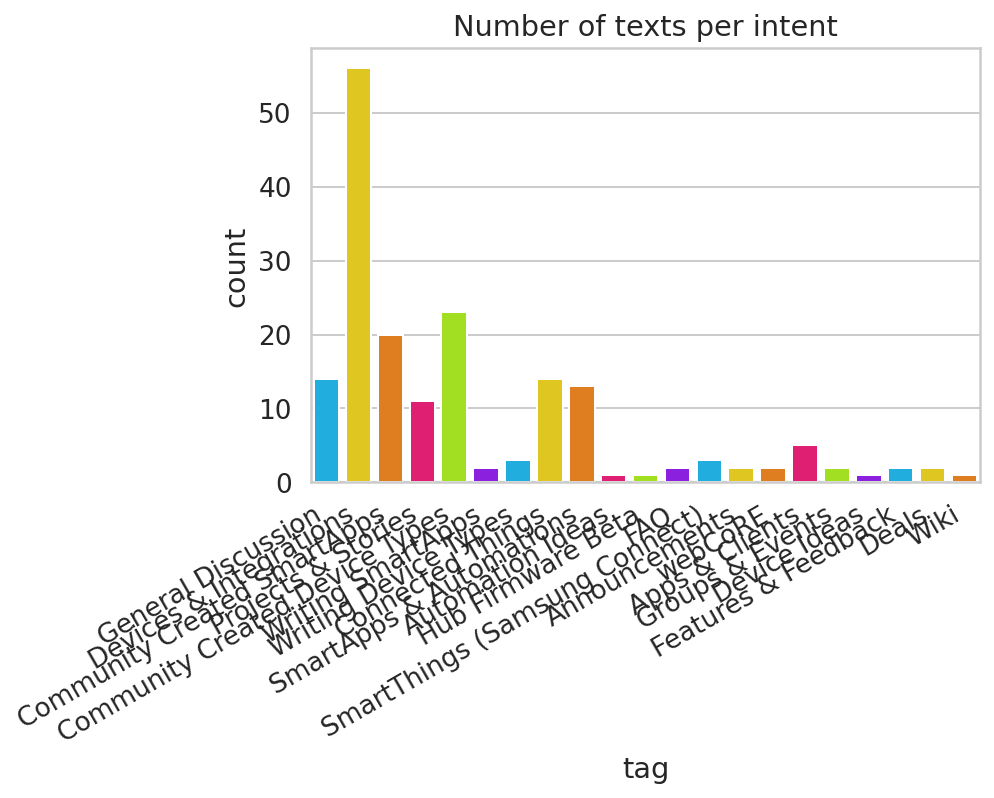

In [6]:
chart = sns.countplot(train.tag, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [21]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-07-01 19:58:34--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  91.3MB/s    in 4.3s    

2020-07-01 19:58:39 (91.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [22]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [23]:
os.makedirs("model", exist_ok=True)

In [24]:
!mv uncased_L-12_H-768_A-12/ model

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


In [7]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [8]:
class IntentDetectionData:
  DATA_COLUMN = "starter_content"
  LABEL_COLUMN = "tag"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      starter_content, tag = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(starter_content)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(tag))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [9]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [10]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [11]:
classes = train.tag.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=512)

180it [00:02, 88.80it/s]
10it [00:00, 284.22it/s]

max seq_len 6957


In [28]:
len(classes)

21

In [12]:
data.train_x.shape

(180, 512)

In [13]:
data.train_x[0]

array([  101, 19102,  9594,  1998, 24969,  2794, 19102,  2694,  2000,
        9594,  2059, 24969,  6047, 20744,  2015,  1998, 24969, 18726,
        2064,  2735,  2694,  2125,  4445,  2097,  2735,  2009,  2006,
        1045,  3543,  2006,  2009,  3065,  2006,  2005,  1037,  3232,
        3823,  2059,  3065,  2125,  2694,  2196,  2941,  4332,  2006,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [14]:
data.train_y[0]

0

In [15]:
data.max_seq_len

512

In [16]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 512, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7c8d9d2630> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 512)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 512, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                16149 

In [18]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [20]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=5,
  shuffle=True,
  epochs=1,
  callbacks=[tensorboard_callback]
)

33/33 [==============================] - 1024s 31s/step - loss: 2.9057 - acc: 0.2716 - val_loss: 2.8902 - val_acc: 0.2222


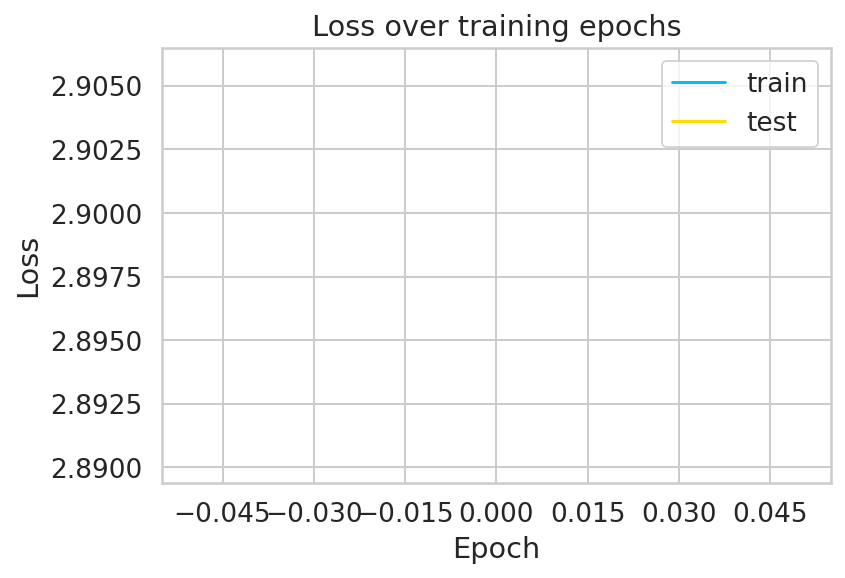

In [21]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [22]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

1/1 [==============================] - 0s 2ms/step - loss: 2.7230 - acc: 0.4000
train acc 0.35555556416511536
test acc 0.4000000059604645


In [23]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [26]:
sentences = [
  "hello i’m having trouble with smartthings home monitor in the new app i have addedinstalled home monitor from the smart apps section in the new app but now when i what to set what sensors to use to monitor the house it sent this kind of message showed on the picture i tried deleting and then adding again but same thing i have smartthings v3 hubeu i have checked my internet connection and everything works just fine so it’s not a internet problem also hub is connected to the internet can someone please help me solve this problem image750×1334 986 kbi think i’m using us english i’m not sure because i don’t know how to check that but i always choose us english for any application that i install i’m not using any malware at all 3 and 4 i did both and since i deleted smartthing app and reinstalled it the caches were cleaned thank you for your response even if this doesn’t help i also reported a problem in smartthings app under contact us so i’m waiting on their response tooi did all that and still reports that same network problem",
  "i have a whole house attic fan that is currently controlled by a highlow rocker switch with a 12 hour timer i would really like to add smart control to it and can’t seem to find one any suggestions alexa enabled would be a plus but i will take any suggestions"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: hello i’m having trouble with smartthings home monitor in the new app i have addedinstalled home monitor from the smart apps section in the new app but now when i what to set what sensors to use to monitor the house it sent this kind of message showed on the picture i tried deleting and then adding again but same thing i have smartthings v3 hubeu i have checked my internet connection and everything works just fine so it’s not a internet problem also hub is connected to the internet can someone please help me solve this problem image750×1334 986 kbi think i’m using us english i’m not sure because i don’t know how to check that but i always choose us english for any application that i install i’m not using any malware at all 3 and 4 i did both and since i deleted smartthing app and reinstalled it the caches were cleaned thank you for your response even if this doesn’t help i also reported a problem in smartthings app under contact us so i’m waiting on their response tooi did all th